<a href="https://colab.research.google.com/github/hrishipoola/groupby_pivottable_crosstab_comparison/blob/main/Groupby%2C_Pivot_table%2C_Crosstab_Comparison_on_Covid_Smell_Loss_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Read in & Process Data
4. Create Dataframe using 3 Methods
<br> Groupby
<br> Pivot_table
<br> Crosstab
5. Timeit() Compare
6. References

## 1. Introduction

We routinely use [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html), [pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html), and [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) along with stack and unstack to pivot data by variables in order to uncover relationships and outliers. I was curious how they actually compared. I came across this [comparison of the three operations](https://ramiro.org/notebook/pandas-crosstab-groupby-pivot/) on varying dataframe sizes by Ramiro Gomez. Today, we'll demonstrate groupby, pivot_table, and crosstab in achieving the same dataframe and compare their ease of use and runtime.

Groupby, pivot_table, and crosstab can be used interchangeably as a matter of choice and data types, though they have subtle differences. As we'll see below, groupby is generally fastest, but it's not as intuitive as pivot_table where the arguments are explicitly stated and requires multiple functions. Pivot_table and crosstab have margin arguments if you want to include aggregates like grand totals. Keep in mind that pivot_table generates a multiindex dataframe and also automatically sorts (groupby has an optional sort argument). Crosstab works similarly to pivot_table, but can take an array or series as input, which may hinder its runtime as it converts to a dataframe at the end. 

We'll work with [data](https://github.com/GCCR/GCCR002) from the [Global Consortium for Chemosensory Research (GCCR)](https://gcchemosensr.org/), a group of scientists, physicians, and patient advocates founded in response to the covid pandemic. I came across their work from a recent New York Times longform piece on the [mysteries of smell](https://www.nytimes.com/2021/01/28/magazine/covid-smell-science.html). 

While the data seems fascinating to explore, let's take a raincheck and focus on comparing groupby, pivot_table, and crosstab. As an example task, we'll create a dataframe that breaks out average loss of smell during covid illness by age group and self-reporting of loss of smell as a symptom. Age groups were created using pd.cut and arbitrary cutoffs. As an FYI, researchers quantified change in smell using a 0-100 visual analog scale. If you're curious, check out GCCR's [study and methodology](https://academic.oup.com/chemse/advance-article/doi/10.1093/chemse/bjaa081/6048917) on using smell loss as a logistic predictor for Covid-19. We'll finally calculate and plot average runtime for each operation using [timeit()](https://docs.python.org/3/library/timeit.html). 

## 2. Install & Import Packages

In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')
import timeit

## 3. Read In & Process Data

In [183]:
df = pd.read_csv('https://raw.githubusercontent.com/GCCR/gccr002/master/data/processed/data-clean.csv')
df.head()

,UniqueID,Test_Name,GCCR,Gender,Respiratory_Illness_y/n,Symptoms_fever,Symptoms_dry_cough,Symptoms_cough_with_mucus,Symptoms_difficulty_breathing_/_shortness_of_breath,Symptoms_chest_tightness,Symptoms_runny_nose,Symptoms_sore_throat,Symptoms_changes_in_food_flavor,Symptoms_changes_in_smell,Symptoms_loss_of_appetite,Symptoms_headache,Symptoms_muscle_aches,Symptoms_fatigue,Symptoms_diarrhea,Symptoms_abdominal_pain,Symptoms_nausea,Smell_before_illness,Smell_during_illness,Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before,Changes_in_smell_smells_smell_different_than_they_did_before_(the_quality_of_smell_has_changed),Changes_in_smell_i_can_smell_things_that_aren't_there_(for_example_i_smell_burning_when_nothing_is_on_fire),Changes_in_smell_sense_of_smell_fluctuates_(comes_and_goes),Blocked_nose_before_illness,Blocked_nose_during_illness,Taste_before_illness,Taste_during_illness,Changes_in_basic_tastes_sweet,Changes_in_basic_tastes_salty,Changes_in_basic_tastes_sour,Changes_in_basic_tastes_bitter,Changes_in_basic_tastes_savory/umami,Chemesthesis_before_illness,Chemesthesis_during_illness,Recovery_y/n,Smell_after_illness,Blocked_nose_after_illness,Taste_after_illness,Chemesthesis_after_illness,Referred_to_survey,Combustible_cigarette_frequency,E-cigarette_30_day_frequency,Prior_conditions_high_blood_pressure,Prior_conditions_heart_disease_(heart_attack_or_stroke),Prior_conditions_diabetes_(high_blood_sugar),Prior_conditions_obesity,Prior_conditions_lung_disease_(asthma/copd),Prior_conditions_head_trauma,Prior_conditions_neurological_disease,Prior_conditions_cancer_that_required_chemotherapy_or_radiation,Prior_conditions_cancer_that_did_not_require_chemotherapy_or_radiation,Prior_conditions_chronic_sinus_problems,Prior_conditions_seasonal_allergies_/_hay_fever,Prior_conditions_none,Age,Completion_day,Onset_day,Smell_change_illness,Smell_recovery_illness,Blocked_nose_change_illness,Blocked_nose_recovery_illness,Taste_change_illness,Taste_recovery_illness,Chemesthesis_change_illness,Chemesthesis_recovery_illness,Days_since_onset,Combustible_cigarette_use,E-cigarette_use,id
0,English_1776,ENGLISH FINAL VERSION!!! [20200514075232],1.0,F,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,100.0,5.7,1.0,0.0,0.0,0.0,2.2,44.0,99.5,33.6,1.0,0.0,0.0,0.0,0.0,54.7,2.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.315068,106,82,-94.3,NaN,41.8,NaN,-65.9,NaN,-52.3,NaN,24,0.5,0.5,English_1776
1,9613Spanish_,SPANISH Results 1 [20200703105503],3.0,M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,2.1,98.4,74.2,0.0,0.0,0.0,0.0,0.0,56.5,56.8,1.0,35.0,4.3,93.8,50.8,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.482192,172,158,-100.0,35.0,2.1,2.2,-24.2,19.6,0.3,-6.0,14,0.5,1.0,9613Spanish_
2,9046Spanish_,SPANISH Results 1 [20200703105503],3.0,M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,4.7,1.0,1.0,0.0,1.0,0.0,51.0,100.0,17.2,1.0,1.0,0.0,1.0,0.0,100.0,39.8,1.0,64.0,53.2,46.5,62.1,2.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.476712,170,87,-95.3,59.3,51.0,2.2,-82.8,29.3,-60.2,22.3,83,0.5,0.5,9046Spanish_
3,Finnish_176,Finnish Final!!! [20200514075405],2.0,F,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.7,87.6,0.0,0.0,1.0,0.0,14.0,27.7,91.8,90.5,0.0,0.0,0.0,0.0,0.0,49.7,49.7,2.0,72.3,68.2,76.8,76.8,2.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34.331507,114,92,-5.1,-15.3,13.7,40.5,-1.3,-13.7,0.0,27.1,22,0.5,0.5,Finnish_176
4,English_3988,ENGLISH FINAL VERSION!!! [20200514075232],2.0,F,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.2,72.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,95.2,21.8,2.0,13.1,5.9,33.7,69.9,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,31.328767,114,86,-100.0,13.1,70.8,-66.1,-100.0,33.7,-73.4,48.1,28,0.5,1.0,English_3988


In [184]:
keep = ['Gender','Symptoms_changes_in_smell','Age','Smell_change_illness']
df = df[keep]
df['Symptoms_changes_in_smell'] = df['Symptoms_changes_in_smell'].map({0.0:'No',1.0:'Yes'}) # Change 0s to No and 1s to Yes
df["Age_group"] = pd.cut(df.Age, [18, 30, 40, 50, 60, 70, 100]) # Create age groups with cutoffs

In [185]:
# We see no nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15747 entries, 0 to 15746
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Gender                     15747 non-null  object  
 1   Symptoms_changes_in_smell  15747 non-null  object  
 2   Age                        15747 non-null  float64 
 3   Smell_change_illness       15747 non-null  float64 
 4   Age_group                  15747 non-null  category
dtypes: category(1), float64(2), object(2)
memory usage: 507.8+ KB


## 4. Create Dataframe using 3 Methods

Create a dataframe that breaks out average loss of smell during covid illness by age group and self-reporting of loss of smell as a symptom.

### Groupby

In [186]:
df.groupby(['Age_group', 'Symptoms_changes_in_smell'])['Smell_change_illness'] \
  .mean() \
  .unstack(fill_value=0)

Symptoms_changes_in_smell,No,Yes
Age_group,,
"(18, 30]",-33.882069,-84.987997
"(30, 40]",-27.756009,-84.806653
"(40, 50]",-26.785863,-83.674355
"(50, 60]",-26.911702,-82.547810
"(60, 70]",-21.579082,-77.918037
"(70, 100]",-20.244681,-75.853472


### Pivot_table

In [187]:
df.pivot_table(index='Age_group', 
               columns='Symptoms_changes_in_smell', 
               values='Smell_change_illness', 
               aggfunc='mean', 
               fill_value=0)

Symptoms_changes_in_smell,No,Yes
Age_group,,
"(18, 30]",-33.882069,-84.987997
"(30, 40]",-27.756009,-84.806653
"(40, 50]",-26.785863,-83.674355
"(50, 60]",-26.911702,-82.547810
"(60, 70]",-21.579082,-77.918037
"(70, 100]",-20.244681,-75.853472


### Crosstab

In [188]:
pd.crosstab(index=df['Age_group'], 
            columns=df['Symptoms_changes_in_smell'], 
            values=df['Smell_change_illness'],
            aggfunc='mean')

Symptoms_changes_in_smell,No,Yes
Age_group,,
"(18, 30]",-33.882069,-84.987997
"(30, 40]",-27.756009,-84.806653
"(40, 50]",-26.785863,-83.674355
"(50, 60]",-26.911702,-82.547810
"(60, 70]",-21.579082,-77.918037
"(70, 100]",-20.244681,-75.853472


All three dataframes are the same

## 5. Timeit() Compare

In [189]:
def groupby(df):
  df.groupby(['Age_group', 'Symptoms_changes_in_smell'])['Smell_change_illness'].mean().unstack(fill_value=0)

def pivot_table(df):
  df.pivot_table(index='Age_group', columns='Symptoms_changes_in_smell', values='Smell_change_illness', aggfunc='mean', fill_value=0)

def crosstab(df):
  pd.crosstab(index=df['Age_group'], columns=df['Symptoms_changes_in_smell'], values=df['Smell_change_illness'],aggfunc='mean')

funcs = [crosstab, groupby, pivot_table]
runtimes = []
repetitions = 10

for func in funcs:
  duration = (timeit.timeit('func(df)', number=repetitions, globals=globals()) / repetitions)*1e6 # average duration in milliseconds
  runtimes.append({'Function': func.__name__, 'duration': duration})

runtimes = pd.DataFrame(runtimes).sort_values(by='duration')

[Text(0, 0.5, ''), Text(0.5, 0, 'Duration (ms)'), Text(0.5, 1.0, 'Runtime')]

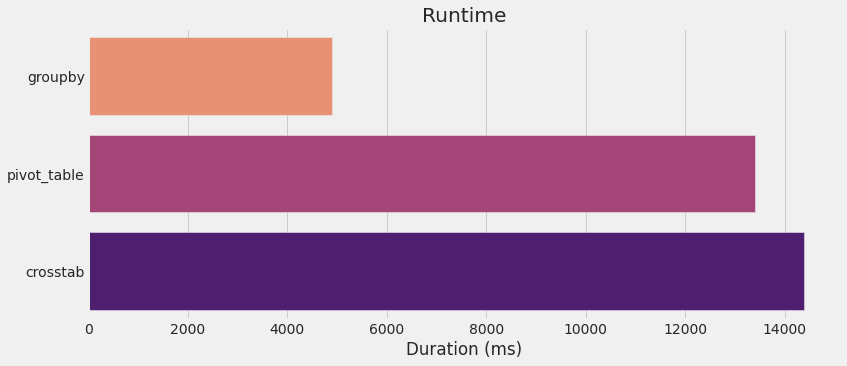

In [201]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='duration', 
            y='Function', 
            data=runtimes, 
            ax=ax,
            palette='magma_r')

ax.set(title='Runtime', xlabel='Duration (ms)',ylabel=None)

In [191]:
runtimes

,Function,duration
1,groupby,4892.0988
2,pivot_table,13410.1364
0,crosstab,14392.1693


Groupby is fastest of the three for this particular task. 

## 6. References

https://ramiro.org/notebook/pandas-crosstab-groupby-pivot/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

https://github.com/GCCR/GCCR002

https://gcchemosensr.org/

https://www.nytimes.com/2021/01/28/magazine/covid-smell-science.html

[Gerkin et al., 'Recent smell loss is the best predictor of COVID-19 among individuals with recent respiratory symptoms', *Chemical Senses*, December 25, 2020](https://academic.oup.com/chemse/advance-article/doi/10.1093/chemse/bjaa081/6048917)

https://docs.python.org/3/library/timeit.html

https://towardsdatascience.com/many-ways-of-pivoting-with-pandas-a763d9653a0

